<a href="https://colab.research.google.com/github/Axis121/AMLS_Project/blob/main/11th_Eye_Colour_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#https://towardsdatascience.com/basic-smile-detection-using-opencv-and-dlib-aeb22afb9e67


In [3]:
import cv2
import dlib
from google.colab.patches import cv2_imshow
from natsort import natsorted # pip install natsort
import os
from os import listdir
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [4]:
def faceLandmarks(im):

    # Path for the detection model, you can download it from here: https://github.com/italojs/facial-landmarks-recognition/blob/master/shape_predictor_68_face_landmarks.dat
    PREDICTOR_PATH = r"/content/drive/MyDrive/Colab Notebooks/Test_folder/shape_predictor_68_face_landmarks.dat"
    
    # Create object to detect the face
    faceDetector = dlib.get_frontal_face_detector()

    # Create object to detect the facial landmarks
    landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

    # Detect faces
    faceRects = faceDetector(im, 0)

    # Initialize landmarksAll array
    landmarksAll = []

    # For each face detected in the image, this chunk of code creates a ROI around the face and pass it as an argument to the 
    # facial landmark detector and append the result to the array landmarks 
    for i in range(0, len(faceRects)):
        newRect = dlib.rectangle(int(faceRects[i].left()),
                            int(faceRects[i].top()),
                            int(faceRects[i].right()),
                            int(faceRects[i].bottom()))
        landmarks = landmarkDetector(im, newRect)
        landmarksAll.append(landmarks)

    return landmarksAll, faceRects


In [5]:
def renderFacialLandmarks(im, landmarks):
    
    # Convert landmarks into iteratable array
    points = []
    [points.append((p.x, p.y)) for p in landmarks.parts()]

    # Loop through array and draw a circle for each landmark
    for p in points:
        cv2.circle(im, (int(p[0]),int(p[1])), 2, (255,0,0),-1)

    # Return image with facial landmarks 
    return im

Extractions of features

In [112]:
def extractFeaturesSingleImage(im_dir): 
  im = cv2.imread(im_dir)
  #left_eye_img = cropEyes(im) # get cropped image of left eye

  # Load the cropped image of the eye
  eye_img = cropEyes(im)

  ## for debjugging cropped eye region
  #from google.colab.patches import cv2_imshow
  #cv2_imshow(eye_img)
  #cv2.waitKey()

  # make empty feature array
  feature_array = np.zeros((1,15))

  # Extract the red, green, and blue channels of the image
  red_channel = eye_img[:,:,2]
  green_channel = eye_img[:,:,1]
  blue_channel = eye_img[:,:,0]

  feature_array[0,0] = np.mean(red_channel)
  feature_array[0,1] = np.mean(green_channel)
  feature_array[0,2] = np.mean(blue_channel)
  feature_array[0,3] = np.median(red_channel)
  feature_array[0,4] = np.median(green_channel)
  feature_array[0,5] = np.median(blue_channel)
  feature_array[0,6] = np.std(red_channel)
  feature_array[0,7] = np.std(green_channel)
  feature_array[0,8] = np.std(blue_channel)
  feature_array[0,9] = np.mean(eye_img)
  feature_array[0,10] = np.median(eye_img)
  feature_array[0,11] = np.std(eye_img)

  ##
  from skimage.feature import greycomatrix, greycoprops

  # Calculate the GLCM for the image
  grey_eye = cv2.cvtColor(eye_img, cv2.COLOR_BGR2GRAY) # convert eye image to balck and white
  glcm = greycomatrix(grey_eye, [1], [0], levels=256, symmetric=True, normed=True)

  # Extract texture features from the GLCM
  feature_array[0,12] = greycoprops(glcm, 'contrast')
  feature_array[0,13] = greycoprops(glcm, 'correlation')
  feature_array[0,14] = greycoprops(glcm, 'homogeneity')

  #print(feature_array) ## for debugging
  return feature_array


In [110]:
def extractFeatures(folder_dir): 
    number_of_features = 15
    features = np.ones((1,number_of_features))*10
    current_features = np.zeros((1,number_of_features))

    for images in natsorted(os.listdir(folder_dir)):
    
        # check if the image ends with png
        if (images.endswith(".png")):
            
            print(images) # for testing
            ##use images to finish the directory call for im
            ## Read an image to a variable
            im = cv2.imread(folder_dir +"/" + images)


            ## Crop image to just the left eye

            ## extract features

            ## return features
            
            # Get landmarks using the function created above
            landmarks, _ = faceLandmarks(im)

            if len(landmarks) == 0: #set features to 0 # no face detected
                
              current_features [0,:]=0
              
            else:
              
              current_features = extractFeaturesSingleImage(folder_dir +"/" + images)

        features = np.vstack((features,current_features))
    
    features = np.delete(features,0,axis = 0) # remove first row, does not represent image
    return features
    print("done")
            

In [8]:
def getLabel(label_dir,column):
  df = pd.read_csv(label_dir)
  #df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Test_folder/dataset/labels_modified.csv')
  #df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/celeba/labels_modified.csv')
  #print(df.iloc[:,3].values)


  # replace() syntax
  df = df.replace(-1,0)
  labels = df.iloc[:,column].values #face shape is the 3rd coloumn, eye colour is the 2nd
  labels = np.transpose(labels)

  return labels

In [9]:
def removeMissingValues (features, labels):

  featuresAndLabels = np.column_stack((features,labels)) # combine the features and labels into one matrix, horizontally
  featuresAndLabels = featuresAndLabels[~np.all(featuresAndLabels[:,:136] == 0, axis=1)] #remove rows if the feature row section is full of zeroes
  clean_features = featuresAndLabels [:,:136] # remake feature matrix
  clean_labels = featuresAndLabels [:,136] # remake label vector

  return clean_features, clean_labels

In [74]:
def cropEyes(img):
  import cv2
  import dlib
  PREDICTOR_PATH = r"/content/drive/MyDrive/Colab Notebooks/Test_folder/shape_predictor_68_face_landmarks.dat"

  # Create a facial landmark detector
  predictor = dlib.shape_predictor(PREDICTOR_PATH)

  # Detect faces in the image
  detector = dlib.get_frontal_face_detector()
  faces = detector(img)

  # Load an image
  ##img = cv2.imread("path/to/image.jpg")

  if len(faces) > 0:
    # Get the facial landmarks for the first face
    shape = predictor(img, faces[0])

    # Get the coordinates for the eyes
    left_eye_x = shape.part(36).x
    left_eye_y = shape.part(36).y
    right_eye_x = shape.part(39).x
    right_eye_y = shape.part(39).y

    # get the width of the rectangle
    eye_distance = right_eye_x - left_eye_x
    rect_width = eye_distance

    # get the height of the rectangle
    eye_to_chin_distance = abs(shape.part(38).y - shape.part(41).y)
    rect_height = eye_to_chin_distance

    # Crop the image to just the region containing the eyes
    left_eye_img = img[left_eye_y-rect_height:left_eye_y+rect_height, left_eye_x:left_eye_x+rect_width]
    #right_eye_img = img[right_eye_y:right_eye_y+rect_height, right_eye_x:right_eye_x+rect_width]

    # Save the cropped images
    cv2.imwrite("left_eye.jpg", left_eye_img)
    #cv2.imwrite("right_eye.jpg", right_eye_img)

    return left_eye_img




In [113]:
#folder_dir = "/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/cartoon_set/img" # training set
folder_dir = "/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/cartoon_set/test" # testing set

features = extractFeatures(folder_dir)
#np.savetxt("real_cartoon_features.csv",features)
#np.save("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B1/feature_backup_2.npy",features)
#np.savetxt("real_cartoon_features_test_set.csv",features)
np.save("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B2/cartoon_small_set.npy",features)

0.png
1.png
2.png
3.png
4.png


KeyboardInterrupt: ignored

In [114]:
print(features)

NameError: ignored

Loading saved features and importing labels

In [8]:
features = np.load("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B2/cartoon_small_set.npy")

In [9]:
#label_dir = '/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/cartoon_set/labels_modified.csv' # training set labels
label_dir = '/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/cartoon_set/test/test_labels.csv' # testing set labels

labels = getLabel(label_dir,column = 1) # get label vector

In [ ]:
print(labels)

[4 4 3 ... 2 2 2]


Removing miss value rows from dataset

In [10]:
clean_features, clean_labels = removeMissingValues (features, labels)

In [ ]:
print(np.shape(clean_labels))

(7984,)


Graph features and lables // only works for bianry classification. Think of how to adapt or remove

In [ ]:
# Scatterplot - Color Change
x = np.random.randn(50)
y1 = np.random.randn(50)
y2= np.random.randn(50)

# Plot
plt.scatter(x,y1,color='blue')
plt.scatter(x,y2,color= 'red')
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

# Decorate
plt.title('Color Change')
plt.xlabel('X - value')
plt.ylabel('Y - value')
plt.show()

<ipython-input-22-d8bb6003fdd7>:3: RuntimeWarning: invalid value encountered in true_divide
  feature_norm = clean_features / clean_features.max(axis=0)


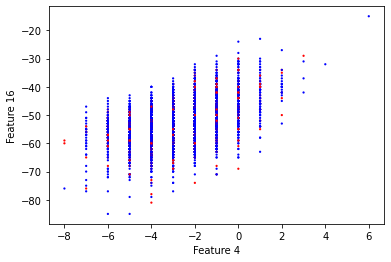

In [ ]:
col = np.where(clean_labels>0,'b','r')

feature_norm = clean_features / clean_features.max(axis=0)

plt.scatter(clean_features[:,1], clean_features[:,6], c=col, s=5, linewidth=0)
plt.xlabel("Feature 4")
plt.ylabel("Feature 16")
plt.show()

Feature selection using select k best and chi test

In [12]:
from sklearn.feature_selection import SelectKBest, chi2

kBest = 60
selected_features = SelectKBest(chi2, k=kBest).fit_transform(abs(clean_features), clean_labels) # choose 30 best features based on chi test, no guideline found for rbf svm but 30 is max for linear svm
selector = SelectKBest(chi2,k=kBest).fit(abs(clean_features), clean_labels)
mask = selector.get_support()  # Get boolean mask of selected features
selected_indices = np.where(mask)[0]  # Convert mask to indices
#X_new.shape

Obtain training and validation sets from feature selected dataset

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_validate, Y_train, Y_validate = train_test_split(selected_features, clean_labels, test_size=0.3,random_state=109) # 70% training and 30% test

Obtain test set from separate directory of images

In [ ]:
##make a check to see if load file exists then reload, if it does not exist then extract.

In [ ]:
## Extract Features
folder_dir = "/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/dataset_AMLS_22-23_test/cartoon_set_test/img" # test set
features = extractFeatures(folder_dir)
np.save("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B1/cartoon_feature_test_set.npy",features) # saving features to a file

In [14]:
## reload features from saved file and get labels
features_test = np.load("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B1/cartoon_feature_test_set.npy")

## labels
label_dir = '/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/dataset_AMLS_22-23_test/cartoon_set_test/modified_labels.csv' # test set labels
labels_test = getLabel(label_dir,1) # get label vector

Process Data

In [15]:
from sklearn.feature_selection import SelectKBest, chi2
## remove missing values
clean_features_test, clean_labels_test = removeMissingValues (features_test, labels_test)

## select 30 best features
# choose 30 best features based on chi test, no guideline found for rbf svm but 30 is max for linear svm
#selected_features_test = SelectKBest(chi2, k=30).fit_transform(abs(clean_features_test), clean_labels_test) 
selected_features_test = abs(clean_features_test[:,selected_indices])

## Match naming convention
X_test = selected_features_test
Y_test = clean_labels_test

In [ ]:
X_test.shape

(1979, 30)

Training and Validation of models

In [38]:
# features required to be normalised to allow convegrence when fitting model
X_validate_normalised = X_validate / X_validate.max(axis=0)
X_train_normalised = X_train / X_train.max(axis=0)
X_test_normalised = X_test / X_test.max(axis=0)

In [16]:
#logistic regression model
logr_model = LogisticRegression(max_iter = 200).fit(X_train, Y_train)
preds = logr_model.predict(X_validate)
print(metrics.classification_report(preds, Y_validate))
metrics.confusion_matrix(Y_validate,preds)

              precision    recall  f1-score   support

         0.0       0.12      0.24      0.16       225
         1.0       0.23      0.25      0.24       454
         2.0       0.12      0.22      0.16       248
         3.0       0.45      0.30      0.36       754
         4.0       0.44      0.30      0.35       715

    accuracy                           0.27      2396
   macro avg       0.27      0.26      0.25      2396
weighted avg       0.34      0.27      0.29      2396



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[ 54,  78,  52, 131, 147],
       [ 49, 112,  50, 155, 131],
       [ 44,  99,  55, 142, 117],
       [ 39,  94,  37, 224, 109],
       [ 39,  71,  54, 102, 211]])

In [17]:
## Tuning hyper parameters of svm rbf model using validation set
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# normalise validation features data
#X_test_normalised = X_validate / X_validate.max(axis=0)

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, Y_train)



Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: ignored

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.0001)


In [ ]:
## Validation ## should evaluate with test set
grid_predictions = grid.predict(X_validate)

# print classification report
print(metrics.classification_report(Y_validate, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.67      0.71      0.69       483
         1.0       0.64      0.56      0.60       452
         2.0       0.65      0.69      0.67       508
         3.0       0.63      0.58      0.60       503
         4.0       0.66      0.70      0.68       450

    accuracy                           0.65      2396
   macro avg       0.65      0.65      0.65      2396
weighted avg       0.65      0.65      0.65      2396



In [23]:
## training tuned model based on training set
## features are max normalised
from sklearn import svm
#feaature should be normalised first
X_validate_normalised = X_validate / X_validate.max(axis=0)
X_train_normalised = X_train / X_train.max(axis=0)

#Create a svm Classifier
rbf_svm_model = svm.SVC(decision_function_shape='ovr',kernel='rbf', class_weight = "balanced") #

#Train the model using the training sets
rbf_svm_model.fit(X_train, Y_train)


SVC(class_weight='balanced')

In [24]:
#Predict the response for test dataset
y_pred = rbf_svm_model.predict(X_test)

print(metrics.classification_report(y_pred, Y_test))
metrics.confusion_matrix(Y_test,y_pred)
cm_svm = metrics.confusion_matrix(Y_test,y_pred)

              precision    recall  f1-score   support

         0.0       0.08      0.21      0.11       146
         1.0       0.18      0.23      0.20       315
         2.0       0.11      0.21      0.14       213
         3.0       0.43      0.29      0.34       601
         4.0       0.49      0.26      0.34       704

    accuracy                           0.26      1979
   macro avg       0.26      0.24      0.23      1979
weighted avg       0.35      0.26      0.28      1979



In [22]:
# distribution of labels
unique, counts = np.unique(Y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0. 398.]
 [  1. 397.]
 [  2. 407.]
 [  3. 397.]
 [  4. 380.]]


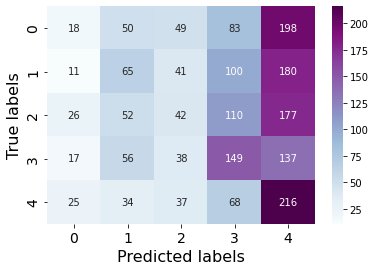

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm_svm, annot=True, fmt='g', ax=ax, cmap="BuPu");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 16);ax.set_ylabel('True labels', fontsize = 16); 
#ax.set_title('Confusion Matrix of the Logistic Classifier'); 
font_size = 14 # Adjust as appropriate.
ax.tick_params(labelsize=font_size)
ax.xaxis.set_ticklabels(['0', '1', "2", "3", "4"]); ax.yaxis.set_ticklabels(['0', '1', "2", "3", "4"]); # x axis = 0, 1 | y axis = 0,1

https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

other models


In [44]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)  
X_test_s = scaler.transform(X_test)
X_validate_s = scaler.transform(X_validate)

#######change max iter, and other params

In [45]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
              'learning_rate': ['constant', 'invscaling', 'adaptive']}

# Create an instance of the MLPClassifier
mlp = MLPClassifier()

# Create an instance of the GridSearchCV object
grid_search = GridSearchCV(mlp, param_grid, cv=5)

# Fit the grid search object to the data
grid_search.fit(X_validate_s, Y_validate)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

Best parameters:  {'alpha': 0.1, 'learning_rate': 'constant'}
Best score:  0.2929845163535142


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [42]:
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
 

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(20, 10, 10), random_state=1)
clf = clf.fit(X_train_s, Y_train)
y_pred_tree = clf.predict(X_test_s)

print(metrics.classification_report(y_pred_tree, Y_test))
metrics.confusion_matrix(Y_test,y_pred_tree)
cm_svm = metrics.confusion_matrix(Y_test,y_pred_tree)

clf.out_activation_

              precision    recall  f1-score   support

         0.0       0.28      0.27      0.28       405
         1.0       0.14      0.21      0.17       273
         2.0       0.11      0.27      0.15       160
         3.0       0.44      0.34      0.39       515
         4.0       0.62      0.37      0.47       626

    accuracy                           0.31      1979
   macro avg       0.32      0.29      0.29      1979
weighted avg       0.40      0.31      0.34      1979



/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


'softmax'

Save the model to be reloaded later

In [ ]:
import pickle

In [ ]:
# save the model to disk
filename = 'B1_svm_model.sav'
pickle.dump(rbf_svm_model, open(filename, 'wb'))

In [ ]:
# load the model from disk
filename = 'B1_svm_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
## Test loaded model
result = loaded_model.score(X_test, Y_test)
print(result)

Examination of Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt

estimator = svm.SVC(decision_function_shape='ovo',kernel='rbf',C=100, gamma=0.0001)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, selected_features, clean_labels, cv = 5, return_times=True)

KeyboardInterrupt: ignored

<function matplotlib.pyplot.show(*args, **kw)>

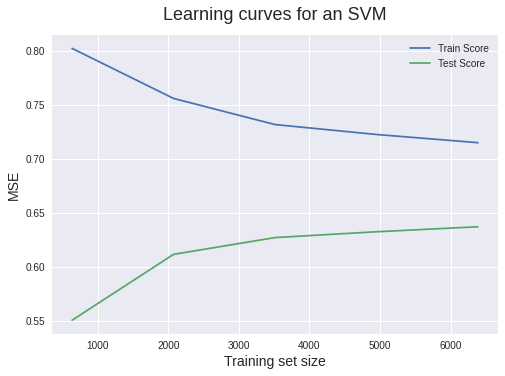

In [ ]:
## plotting learning curve
plt.style.use('seaborn')
plt.plot(train_sizes,np.mean(train_scores,axis=1))
plt.plot(train_sizes,np.mean(test_scores,axis=1))
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for an SVM', fontsize = 18, y = 1.03)
plt.legend(["Train Score", "Test Score"])
plt.show

In [ ]:
print(train_sizes)

[ 638 2075 3512 4949 6387]
